In [ ]:
#@title Installieren der Libraries
#@markdown Dieser Abschnitt installiert alle nötigen Libraries.
!pip install xmltodict
!pip install entsoe-py
!pip install pandas
!pip install seaborn
!pip install plotly
!pip install matplotlib

In [ ]:
#@title Importieren der Libraries
#@markdown Dieser Abschnitt lädt die nötigen Libraries.
import requests
import pandas as pd
import xmltodict
from datetime import timedelta
from matplotlib import pyplot as plt
from entsoe import EntsoePandasClient
import seaborn as sns
import warnings

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from IPython.display import FileLink


warnings.filterwarnings("ignore")
pd.options.plotting.backend = "plotly"


In [ ]:
#@title Beispiel ENTSOE API Anfrage
#@markdown Wir machen eine Anfrage an die ENTSOE API und zeigen die Antwort an auf der folgenden URL an.

#@markdown Die Antwort der ENTSOE API ist kryptisch mit vielen Codes. Das Formatieren ist auch mit programmieren umständlich.
#@markdown Aber zum Glück hat das schon jemand gemacht. Das heisst, wir können einfach eine Helfer-Library nutzen....

#@markdown https://web-api.tp.entsoe.eu/api?securityToken={MYTOKEN}&documentType=A75&processType=A16&in_Domain=10YIE-1001A00010&periodStart=202308130000&periodEnd=202308170000"


MYTOKEN="c81dca9c-4b53-4d16-9aa9-5674723d728a"


api_request_url=f"https://web-api.tp.entsoe.eu/api?securityToken={MYTOKEN}&documentType=A75&processType=A16&in_Domain=10YIE-1001A00010&periodStart=202308130000&periodEnd=202308170000"
response=requests.get(api_request_url)
raw_xml=response.content
raw_json = xmltodict.parse(raw_xml)
raw_json


{'GL_MarketDocument': {'@xmlns': 'urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0',
  'mRID': '3595b47f3da64f31873237230dd0f438',
  'revisionNumber': '1',
  'type': 'A75',
  'process.processType': 'A16',
  'sender_MarketParticipant.mRID': {'@codingScheme': 'A01',
   '#text': '10X1001A1001A450'},
  'sender_MarketParticipant.marketRole.type': 'A32',
  'receiver_MarketParticipant.mRID': {'@codingScheme': 'A01',
   '#text': '10X1001A1001A450'},
  'receiver_MarketParticipant.marketRole.type': 'A33',
  'createdDateTime': '2024-10-18T11:36:42Z',
  'time_Period.timeInterval': {'start': '2023-08-13T00:00Z',
   'end': '2023-08-17T00:00Z'},
  'TimeSeries': [{'mRID': '1',
    'businessType': 'A01',
    'objectAggregation': 'A08',
    'inBiddingZone_Domain.mRID': {'@codingScheme': 'A01',
     '#text': '10YIE-1001A00010'},
    'quantity_Measure_Unit.name': 'MAW',
    'curveType': 'A01',
    'MktPSRType': {'psrType': 'B04'},
    'Period': {'timeInterval': {'start': '2023-08-13T00:00Z',
   

In [ ]:
#@title Verteilung der Stromerzeugung in der Schweiz
#@markdown Wir rufen die den API-Helfer ab, um die Daten zu sammeln und eine Tabelle zu erstellen. Anschliessend stellen wir die Daten in einer interaktiven Grafik dar.

#@markdown https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/data-views/generation/Data-view%20Actual%20Generation%20per%20Production%20Unit.html
# Helfer
client = EntsoePandasClient(api_key=MYTOKEN)

# Abfrage Parameter
country_code = 'CH'
start = pd.Timestamp('20150101', tz='Europe/Brussels')
end = pd.Timestamp('20211231', tz='Europe/Brussels')

# Abfrage mit dem Helfer starten
generation = client.query_generation(country_code, start=start, end=end, psr_type=None)

# Daten kommen stündlich, wir sind aber am Total pro Jahr interessiert.
# Wir lesen das Jahr aus...
generation['year']=generation.index.year
# ... und summieren alle Werte.
generation=generation.groupby('year').sum()

# Anzeigen der Tabelle
display(generation.head(5))

# Anzeigen als Bar plot
fig=generation.plot.bar(title="Generation")

# Anpassen der Beschriftungen
fig.update_layout(
    title="Verteilung der Stromerzeuger in der Schweiz jährliches Total",
    yaxis_title="[MWh]",
    xaxis_title="Jahr",
    legend_title="Stromerzeuger"
)

# Um die Abbildung im Notebook darzustellen, speichern wir sie als html
fig.write_html("generation_per_type_ch.html")
FileLink("generation_per_type_ch.html")


,Fossil Gas,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Solar,Wind Onshore
year,,,,,,,
2015,24874.0,2271738.0,92614.0,5346578.0,7736636.0,214405.0,52377.0
2016,0.0,5130746.0,587042.0,7946400.0,19716760.0,336030.0,68466.0
2017,0.0,6599992.0,687032.0,8860713.0,19621301.0,421112.0,79205.0
2018,0.0,6885784.0,1534163.0,10290331.0,24803873.0,352168.0,57509.0
2019,0.0,7679075.0,1946572.0,11860973.0,25721400.0,419482.0,79972.0


In [ ]:
#@title Kraftwerksausfälle in der Schweiz - aufgeschlüsselt nach Stromerzeuger
#@markdown Wir rufen die den API-Helfer ab um die Daten zu sammeln und eine Tabelle zu erstellen. Anschliessend stellen wir die Daten in einer interaktiven Grafik dar.

#@markdown https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/data-views/outage-domain/Data-view%20Unavailability%20of%20Production%20and%20Generation%20Units.html

# Abfrage Parameter
country_code='CH'
start = pd.Timestamp('20160101', tz='Europe/Brussels')
end = pd.Timestamp('20231231', tz='Europe/Brussels')

# Abfrage mit dem Helfer starten
outage=client.query_unavailability_of_generation_units(country_code, start=start, end=end, docstatus="A05", periodstartupdate=None, periodendupdate=None)

# Wir filtern nach ungeplannten Ausfällen
unplanned_outage=outage[outage['businesstype']=='Unplanned outage'].copy()

# Die API liefert einige Werte vor dem Startjahr. Wir filtern diese raus.
unplanned_outage['year']=unplanned_outage.index.year
unplanned_outage=unplanned_outage[unplanned_outage['year']!=2015]
unplanned_outage=unplanned_outage[unplanned_outage['year']!=2024]

# Wir machen eine Pivottabelle um alle Ausfälle nach Stromerzeuger aufzuteilen.
unplanned_outage_pivot=unplanned_outage.pivot_table(index='year',columns='plant_type',values='start',aggfunc='count').fillna(0)

# Anzeigen der Tabelle
display(unplanned_outage_pivot.head(5))

# Anzeigen als Area plot
fig=unplanned_outage_pivot.plot.area(title='Unplanned outages')

# Anpassen der Beschriftungen
fig.update_layout(
    title="Ungeplante Netzausfälle pro Jahr in der Schweiz",
    yaxis_title="# Ausfälle",
    xaxis_title="Jahr",
    legend_title="Stromerzeuger"
)

# Um die Abbildung im Notebook darzustellen, speichern wir sie als html
fig.write_html("outages_per_type_ch.html")
FileLink("outages_per_type_ch.html")


plant_type,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear
year,,,,
2016,14.0,0.0,17.0,11.0
2017,57.0,0.0,39.0,14.0
2018,215.0,0.0,40.0,6.0
2019,182.0,1.0,48.0,14.0
2020,272.0,0.0,40.0,5.0


,timestamp,price_ahead,country_code,hour,weekday,month,Land
8731,2023-12-30 19:00:00+01:00,71.09,FR,18,Saturday,December,FR
8732,2023-12-30 20:00:00+01:00,62.01,FR,19,Saturday,December,FR
8733,2023-12-30 21:00:00+01:00,28.73,FR,20,Saturday,December,FR
8734,2023-12-30 22:00:00+01:00,50.10,FR,21,Saturday,December,FR
8735,2023-12-30 23:00:00+01:00,43.23,FR,22,Saturday,December,FR


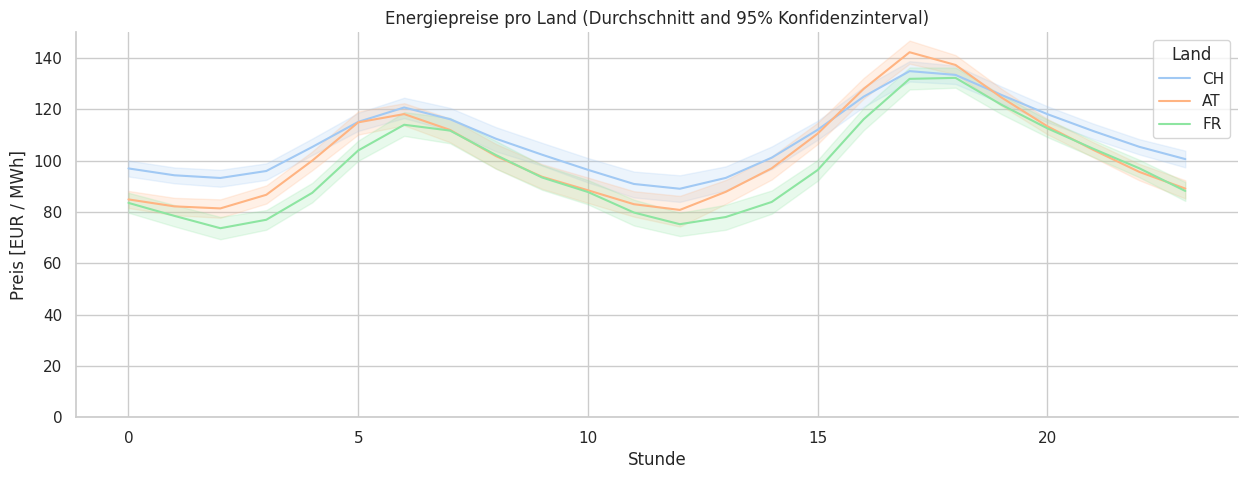

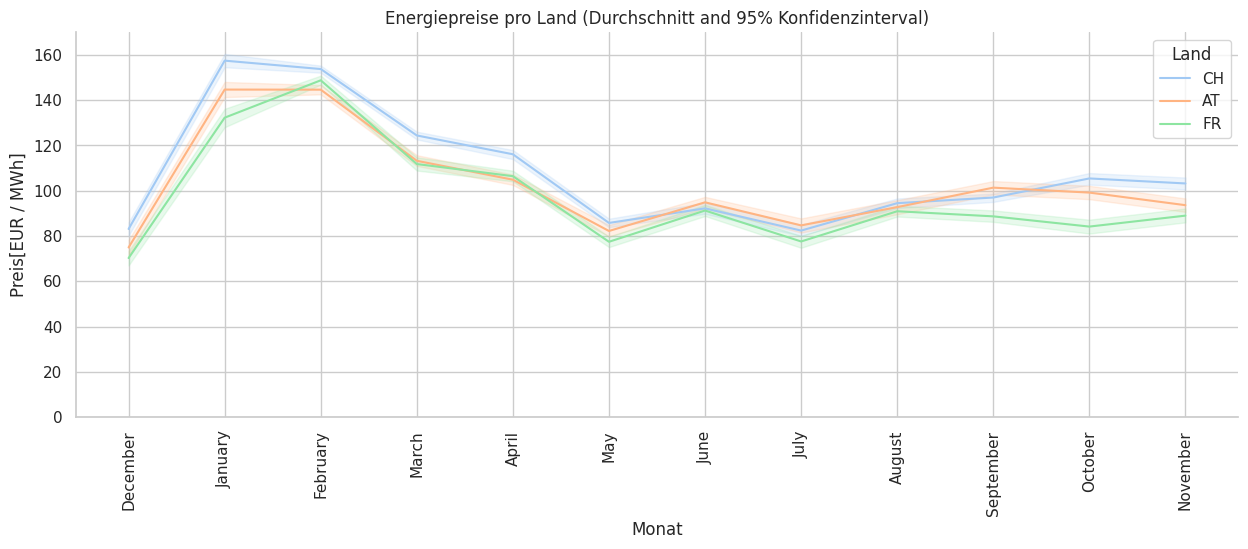

In [ ]:
#@title Stromgrosshandelspreise im internationalen Vergleich
#@markdown **=> Durchschnittspreis des heute an der Börse gekauften Stroms für den folgenden Tag** \
#@markdown Wir rufen die den API-Helfer ab um die Daten zu sammeln und eine Tabelle zu erstellen. Anschliessend stellen wir die Daten in einer interaktiven Grafik dar.


#@markdown https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/data-views/transmission-domain/Data-view%20Day-ahead%20prices.html

# Abfrage Parameter
country_codes = [
    "CH",
    "DE",
    "IT",
    "AT",
    "FR"
]
start = pd.Timestamp('20230101', tz='Europe/Brussels')
end = pd.Timestamp('20231231', tz='Europe/Brussels')

# Wir fragen die Preise for jedes Land in der Liste ab
dfs = []
for country_code in country_codes:
    # Nicht alle Länder publizieren die Preise. Wir versuchen Werte zu erhalten
    try:
        # Wir erhalten die Preise in einem Dataframe...
        response=client.query_day_ahead_prices(country_code, start=start, end=end).to_frame().reset_index().rename(columns={"index": "timestamp", 0: "price_ahead"}).assign(country_code=country_code)
        # ... und fügen sie der Liste hinzu
        dfs.append(response)
    # Falls keine Werte für das Land vorhanden machen wir nichts
    except:
        pass

# Wir verbinden die Daten aller Länder zu einer Tabelle
df = pd.concat(dfs)

# Wir extrahieren die Stunde, Monat und Wochentag vom Datum
df["hour"] = pd.to_datetime(df["timestamp"], utc=True).dt.hour
df["weekday"] = pd.to_datetime(df["timestamp"], utc=True).dt.day_name()
df["month"] = pd.to_datetime(df["timestamp"], utc=True).dt.month_name()
df['Land']=df['country_code']

# Anzeigen der Tabelle
display(df.tail(5))

# Parameter für schönere Darstellung
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="pastel", rc=custom_params)

# Anzeige als Liniendiagramm mit Varianz für die Stunde
plt.figure(figsize=(15,5))
ax = sns.lineplot(
    x="hour",
    y="price_ahead",
    hue="Land",
    data=df
)

# Anpassen der Beschriftung
ax.set_ylabel("Preis [EUR / MWh]")
ax.set_xlabel("Stunde")
ax.set_ylim([0, 150])
ax.set_title("Stromgrosshandelspreise pro Land (Durchschnitt and 95% Konfidenzinterval)")
plt.show()

# Anzeige als Liniendiagramm mit Varianz für den Monat
plt.figure(figsize=(15,5))
ax = sns.lineplot(
    x="month",
    y="price_ahead",
    hue="Land",
    data=df

)

# Anpassen der Beschriftung
ax.set_ylabel("Preis[EUR / MWh]")
ax.set_xlabel("Monat")
ax.set_ylim([0, 170])
ax.set_title("Stromgrosshandelspreise pro Land (Durchschnitt and 95% Konfidenzinterval)")
plt.xticks(rotation=90);



In [ ]:
#@title Energie Defizit der Schweiz zu Nachbarstaaten
#@markdown Wir rufen die den API-Helfer ab um die Daten zu sammeln und eine Tabelle zu erstellen. Anschliessend stellen wir die Daten in einer interaktiven Grafik dar.
#@markdown Positives Defizit bedeuted Export, negatives bedeuted Import.

#@markdown https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/data-views/balancing/Data-view%20Cross-Border%20Balancing.html

# Abfrage Parameter
start = pd.Timestamp('20230101', tz='Europe/Brussels')
end = pd.Timestamp('20231231', tz='Europe/Brussels')

# Wir fragen den Export und Import zu jedem Nachbarland ab
energy_deficit=[]
for neighbor in ['DE','AT','FR','IT']:
  export_flow=client.query_crossborder_flows(country_code,neighbor, start=start, end=end)
  import_flow=client.query_crossborder_flows(neighbor,country_code, start=start, end=end)

  # Wir erhalten das defizit als die Different von Export und Import
  deficit=export_flow-import_flow

  # Wir erhalten stündliche Daten. Wir wollen aber tägliche. Wir extrahieren das Datum...
  deficit.index=deficit.index.date
  #... und summieren alle Werte eines Tages auf
  deficit=deficit.groupby(level=0).sum()
  # Wir geben den Daten einen Namen
  deficit.name=f"{neighbor}"
  # Und fügen sie einer Liste hinzu
  energy_deficit.append(deficit)

# Wir verbinden die Daten aller Nachbarländer zu einer Tabelle
energy_deficit=pd.concat(energy_deficit,axis=1)


# Anzeigen der Tabelle
display(energy_deficit.head(5))

# Anpassen als Bar plot
fig=energy_deficit[['AT','FR','IT','DE']].plot.bar(barmode = "relative")
fig.update_layout(
    title="Energiedefizit Schweiz",
    yaxis_title="Defizit [MWh]",
    xaxis_title="Datum",
    legend_title="Nachbarland"
)

# Um die Abbildung darzustellen, speichern wir sie als html
fig.write_html("netto_import_ch.html")
FileLink("netto_import_ch.html")



,DE,AT,FR,IT
2022-12-31,-8532.0,-591.0,-396.0,1777.0
2023-01-01,-86007.0,-5862.0,-25761.0,34935.0
2023-01-02,-3928.0,196.0,-35852.0,31392.0
2023-01-03,-98444.0,-8618.0,-53655.0,75819.0
2023-01-04,-264891.0,-23135.0,-54795.0,96634.0


In [ ]:
#@title Energie Defizit im Vergleich zu den Energiepreisen
#@markdown Wir rufen die den API-Helfer ab um die Daten zu sammeln und eine Tabelle zu erstellen. Anschliessend stellen wir die Daten in einer interaktiven Grafik dar.
#@markdown Damit der Vergleich einfacher ist haben wir das Defizit gespiegelt. Positive = Import, Negative = Export

# Wir machen eine zweite Achse um zwei verschiedene Skalen zu haben
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Wir summieren das Energiedefizit zu jedem Nachbarland auf um das Total Defizit zu erhalten.
neg_defitic=(-energy_deficit[['AT','FR','IT','DE']].sum(axis=1))
# Wir nehmen den 7 Tage Schnitt um weniger Fluktuation zu haben
neg_defitic=neg_defitic.rolling(7,center=True).mean()

# Wir geben der neuen Datenserie einen treffenden Namen
neg_defitic.name='Gespiegeltes Energiedefizit'

# Anzeigen des Defizits
fig_tmp=neg_defitic.plot()
fig.add_traces(fig_tmp.data)

# Wir filtern nach den Day-Ahead Preisen von der Schweiz
prices_CH=df[df['country_code']=='CH']
# Wir extrahieren das Datum
prices_CH.index=pd.to_datetime(prices_CH['timestamp']).dt.date
# Wir nehmen den 7 Tage Schnitt um weniger Fluktuation zu haben
prices_CH=prices_CH['price_ahead'].rolling(24*7,center=True).mean()

# Anzeigen der Day- Ahead Preise
fig.add_trace(go.Scatter(x= prices_CH.index, y=prices_CH, mode = 'lines',name='Day Ahead Preise'),secondary_y=True)

# Beschriften der Achsen
fig.update_layout(

    title="Energiedefizit vs. Energiepreise Schweiz",
    yaxis_title="-Defizit [MWh]",
    yaxis2_title="Price per MTU [EUR / MWh]",
    xaxis_title="Datum",
    legend_title="Nachbarland"
)

# Um die Abbildung darzustellen, speichern wir sie als html
fig.write_html("price_vs_nettoimport.html")
FileLink("price_vs_nettoimport.html")

